<a href="https://colab.research.google.com/github/ericodosreis/MBA_Analise_Preditiva_Avancada-Trabalho_XRAY/blob/main/X_Ray_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**FGV** 

**MBA BUSINESS ANALYTICS AND BIG DATA**



Adriana Marques Guidi A58318039

Érico dos Reis A58239101

Mário Elias AXXXX

Rodrigo Nakamura


CNN para classificação de Raio-X

Campinas - SP
Agosto, 2021




O seguinte estudo tem por finalidade classificar pacientes com ou sem pneumonia, através da avaliação de imagens de raio x.

Cada passa abaixo, indica as etapas e metodologias utilizadas para desenvovler o modelo convolucional e avaliar sua eficácia. 

PASSO 1. Importar bibliotecas

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

import cv2 # OpenCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

#!pip install "tensorflow"
#!pip install "keras"
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

PASSO 2. Conjunto de dados

- Os dados serão rotulados como "pneumonia bacteria" e "normal"

- Os dados serão redimensionados para reduzir o tempo computacional de aprendizado

- Carregar os dados através de uma API que indica o caminho a ser carregado. Neste caso utilizamos dois diretórios para amostra de treinamento e validação

- Dividir a base de dados "treinamento_raw" em treinamento e teste

In [ ]:
LABELS = ('PNEUMONIA BACTERIA','NORMAL')
IMG_SIZE=150
def get_data(data_dir):
    data = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [ ]:
treinamento_raw = get_data('/content/drive/My Drive/Colab Notebooks/chest_xray/treinamento/')
validacao_raw = get_data('/content/drive/My Drive/Colab Notebooks/chest_xray/validacao/')


NameError: ignored

In [ ]:
treinamento_raw, teste_raw = train_test_split(treinamento_raw, train_size=0.8)


NameError: ignored

PASSO 3. Explorar os dados através das imagens divididas em grupo "normal" e "pneumonia".

- Após a segregação é possível visualizar as imagens nos grupos definidos.

In [ ]:
# Training Data
count = []
for i in treinamento_raw:
    if(i[1] == 1):
        count.append("Normal")
    else:
        count.append('Pneumonia')

sns.countplot(count)

NameError: ignored

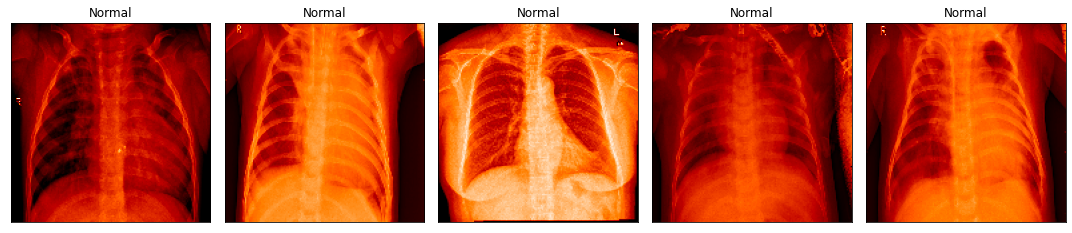

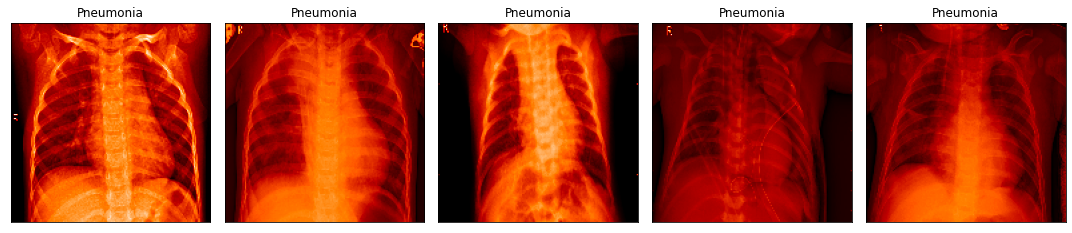

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
#     if (treinamento_raw[i][1] == 1):
        img = treinamento_raw[i][0]
        ax.imshow(img, cmap='gist_heat')
        ax.set_title("Normal")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
#     if (treinamento_raw[i][1] == 0):
        img = treinamento_raw[-(i+1)][0]
        ax.imshow(img, cmap='gist_heat')
        ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

PASSO 4. Dividindo e normalizando os dados

- Os dados serão divididos em bases de X%treinamento, Y%validação e Z%teste

- Os dados serão normalizados de 0-255 para 0-1 para que todos os dados estejam na mesma escala de grandeza e facilitar a aplicação do gradiente descendente

- Os dados serão redimensionados para reduzir o tempo computacional de aprendizado

In [ ]:
X_treinamento = []
y_treinamento = []

X_validacao = []
y_validacao = []

X_teste = []
y_teste = []

for image, label in treinamento_raw:
    X_treinamento.append(image)
    y_treinamento.append(label)
    
for image, label in validacao_raw:
    X_validacao.append(image)
    y_validacao.append(label)

for image, label in teste_raw:
    X_teste.append(image)
    y_teste.append(label)


In [ ]:
X_treinamento = np.array(X_treinamento) / 255
X_validacao = np.array(X_validacao) / 255
X_teste = np.array(X_teste) / 255

In [ ]:
X_treinamento = X_treinamento.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_treinamento = np.array(y_treinamento)

X_validacao = X_validacao.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_validacao = np.array(y_validacao)

X_teste = X_teste.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_teste = np.array(y_teste)

PASSO 5. Expandindo o conjunto de dados

- Para evitar overfitting expandimos o conjunto de dados de treinamento a partir dos dados existentes. O processo de expansão trata-se da manipulação das imagens ja existentes, fornecendo mais imagens a serem treinadas e com isso produzir um modelo mais robusto, consequentemente um modelo que consegue generalizar em mais cenários distintos. Seguiremos o pré processamento conforme indicações no código.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # média de entrada definida como zero
        samplewise_center=False,  # média da amostra definida como zero
        featurewise_std_normalization=False,  # dividir entradas por padrões do conjunto de dados
        samplewise_std_normalization=False,  # dividir cada entrada por seus padrões
        zca_whitening=False,  # ampliar clareamento ZCA
        rotation_range = 30,  # girar imagens aleatoriamente entre 0 e 180 graus
        zoom_range = 0.2, # ampliar imagens aleatoriamente 
        width_shift_range=0.1,  # deslocar as imagens aleatoriamente na horizontal
        height_shift_range=0.1,  # deslocar imagens aleatoriamente na vertical
        horizontal_flip = True,  # virar as imagens aleatoriamente na horizontal
        vertical_flip=False)  # virar imagens aleatoriamente na vertical


datagen.fit(X_treinamento)

PASSO 6. Modelo de treinamento
- A estrutura da rede neural foi criada através de camadas convolucionais 2D e MaxPool 2D, função de ativação das camadas de entrada e escondidas como relu e de saída aplicaremos a função sigmoide para obtermos resultados entre 0 e 1
- Como parametros de otimização da rede neura foi aplicado optimizer "rmsprop"
- Para rodar modelo de treinamento, rodaremos *****18 epocas e ao final teremos a acurácia do nosso modelo
- MUSAR SET SEED


In [ ]:
np.random.seed = 18
NUM_EPOCHS = 18

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (160,160,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 160, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0

MUDAR min_lr=1 ************************

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

history = model.fit(datagen.flow(X_treinamento, y_treinamento, batch_size = 32),
                    epochs = NUM_EPOCHS,
                    validation_data = datagen.flow(X_validacao, y_validacao),
                    callbacks = [learning_rate_reduction]
                   )

Epoch 1/18
94/94 [==============================] - 195s 2s/step - loss: 2.4808 - accuracy: 0.7639 - val_loss: 12.9743 - val_accuracy: 0.3740
Epoch 2/18
94/94 [==============================] - 174s 2s/step - loss: 0.3252 - accuracy: 0.8891 - val_loss: 15.3407 - val_accuracy: 0.3740
Epoch 3/18
94/94 [==============================] - 174s 2s/step - loss: 0.2666 - accuracy: 0.9054 - val_loss: 18.8537 - val_accuracy: 0.3740

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/18
94/94 [==============================] - 174s 2s/step - loss: 0.1803 - accuracy: 0.9356 - val_loss: 12.1073 - val_accuracy: 0.3740
Epoch 5/18
94/94 [==============================] - 174s 2s/step - loss: 0.1481 - accuracy: 0.9493 - val_loss: 5.5616 - val_accuracy: 0.3969
Epoch 6/18
94/94 [==============================] - 174s 2s/step - loss: 0.1388 - accuracy: 0.9488 - val_loss: 1.2553 - val_accuracy: 0.7176
Epoch 7/18
94/94 [==============================] - 175s 2s/step - lo

PASSO 6.1 Avaliação do modelo na base de teste, que obtem resultado de XXXX e falha de YYYY

In [ ]:
print("A Falha do Modelo é de - " , model.evaluate(X_teste,y_teste)[0])
print("A Precisão do Modelo é de - " , model.evaluate(X_teste,y_teste)[1]*100 , "%")

24/24 [==============================] - 9s 351ms/step - loss: 0.1949 - accuracy: 0.9241
A Falha do Modelo é de -  0.19490711390972137
24/24 [==============================] - 9s 357ms/step - loss: 0.1949 - accuracy: 0.9241
A Precisão do Modelo é de -  92.4101173877716 %


PASSO 7: Análise visual dos resultados

Os gráficos apresentam visualmente os resultados a respeito do treinamento do modelo. Ambos demostram a partir da décima segunda época não há mais grandes diferenças nem na acurácia, nem na falha.

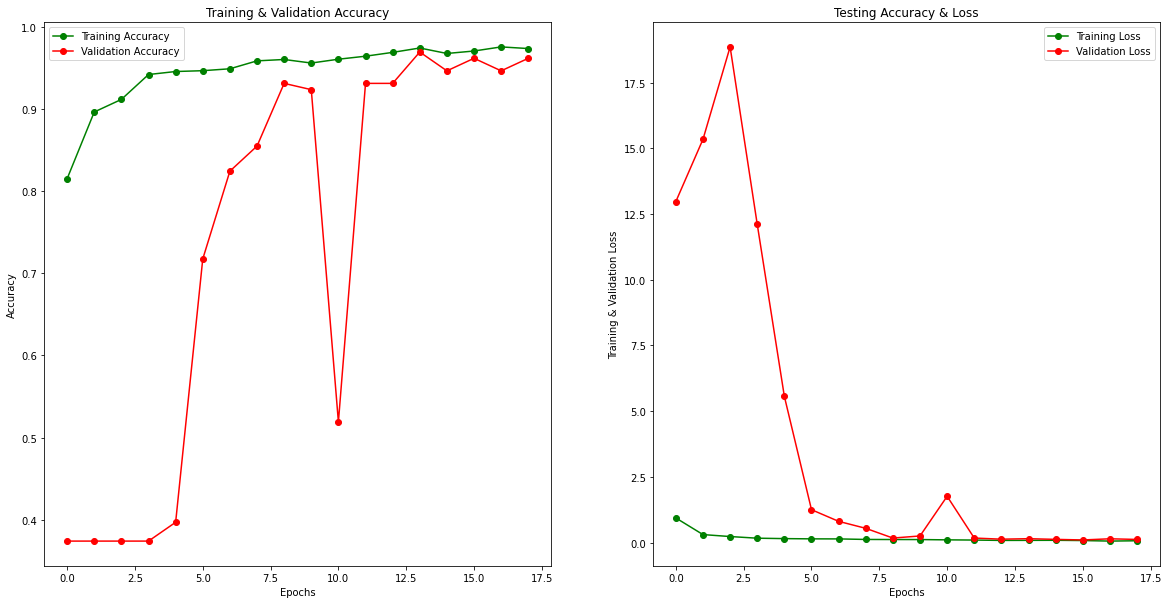

In [ ]:
#Analise do treino

epochs = [i for i in range(NUM_EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

PASSO 8. Análise do desempenho do modelo

- A precisão do modelo indica que a cada 100 pacientes da amostra, apenas 1 não foi classificado corretamente;
- O recall do modelo indica 89% dos pacientes com pneumonia foram classificados corretamente;
- O f1 demostra que o equilibro entre a precisão e o recall deste modelo é 94%.

In [ ]:
#Model analysis

y_preds = model.predict_classes(X_teste)
y_preds = y_preds.reshape(1,-1)[0]
y_preds

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,

In [ ]:
# Classification report
print(classification_report(y_teste, y_preds, target_names= ['Pneumonia (0)', 'Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       0.99      0.89      0.94       491
   Normal (1)       0.83      0.99      0.90       260

     accuracy                           0.92       751
    macro avg       0.91      0.94      0.92       751
 weighted avg       0.94      0.92      0.93       751



PASSO 9. Matriz de confusão

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(y_teste, y_preds), annot=True, fmt='', xticklabels=['Pneumonia','Normal'], yticklabels=['Pneumonia','Normal'])


In [ ]:
#Predictions

correto = np.nonzero(y_preds == y_teste)[0]
incorreto = np.nonzero(y_preds != y_teste)[0]
correto[:10], incorreto[:10]


(array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([  2,  11,  17,  19,  21,  43,  61,  96, 122, 146]))

In [ ]:
def plot_preds(correct, incorrect, X_test, y_test, n=4, corr=True):
    """
    Prints correct or incorrect predictions.
    """
    labels=['pneumonia', 'normal']
    
    plt.figure(figsize=(10,15))
    
    # Correct
    if corr:
        print("Correct predictions:\n")
        i=0
        for c in correct[:n]:
            plt.subplot(((n+1)//2)+1, 2, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(X_test[c])
            plt.title(f'Predicted: {labels[y_preds[c]]}, Actual: {labels[y_test[c]]}')
            plt.tight_layout()
            i+=1

    # Incorrect
    else:
        print("Incorrect predictions:\n")
        i=0
        for inc in incorrect[:n]:
            plt.subplot(((n+1)//2)+1, 2, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(X_test[inc])
            plt.title(f'Predicted: {labels[y_preds[inc]]}, Actual: {labels[y_test[inc]]}')
            plt.tight_layout()
            i+=1

Correct predictions:



TypeError: ignored

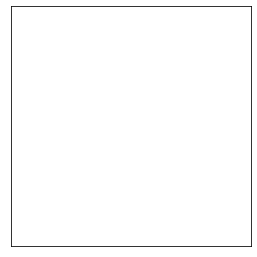

In [ ]:
plot_preds(correto, incorreto, X_teste, y_teste)

Previsões Incorretas:



TypeError: ignored

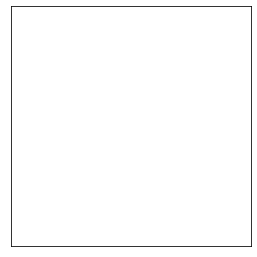

In [ ]:
plot_preds(correto, incorreto, X_teste, y_teste, corr=False)

In [ ]:
#Conclusion
# Model shows a reasonable precision of 92% and f-1 score of 0.92. 
# Additional preprocessing of the images and tuning of the model could be performed to improve this score, but it has passed the evaluation metric for this version.